In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
import scipy
import datetime
import seaborn as sn
from collections import Counter
import re
from itertools import chain, islice
import requests
import urllib.request
import time
from bs4 import BeautifulSoup

In [2]:
dat= pd.read_csv('TopCharts_complete.csv')

In [3]:
print(dat.head())

   rank        date            artist                                title  \
0     1  2017-01-01             Migos  Bad and Boujee (feat. Lil Uzi Vert)   
1     2  2017-01-01             Drake                            Fake Love   
2     3  2017-01-01        The Weeknd                              Starboy   
3     4  2017-01-01  The Chainsmokers                               Closer   
4     5  2017-01-01      Rae Sremmurd                        Black Beatles   

     streams  danceability  energy   key  loudness  mode  speechiness  \
0  1,371,493         0.927   0.665  11.0    -5.313   1.0       0.2440   
1  1,180,074         0.928   0.481   9.0    -9.350   0.0       0.2870   
2  1,064,351         0.679   0.587   7.0    -7.015   1.0       0.2760   
3  1,010,492         0.748   0.524   8.0    -5.599   1.0       0.0338   
4    874,289         0.794   0.632   0.0    -6.163   1.0       0.0649   

   acousticness  instrumentalness  liveness  valence    tempo  \
0         0.061          0.

In [4]:
print(dat.dtypes) # type of each feature

rank                  int64
date                 object
artist               object
title                object
streams              object
danceability        float64
energy              float64
key                 float64
loudness            float64
mode                float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
uri                  object
duration_ms         float64
time_signature      float64
dtype: object


In [5]:
# we see problem with 'streams' feature being a string due to the commas present in the numbers
dat_copy = dat.copy()
dat_copy.streams = dat_copy.streams.str.replace(',', '') # remove commas
dat_copy.streams = dat_copy.streams.astype(int) # convert to int
dat.loc[:,'streams'] = dat_copy['streams']
print(dat.streams.head())

0    1371493
1    1180074
2    1064351
3    1010492
4     874289
Name: streams, dtype: int32


In [6]:
# examine correlation between numeric features
dat.select_dtypes(exclude=['object']).corr()

,rank,streams,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
rank,1.000000,-0.724975,-0.083407,0.025537,0.018969,-0.015841,0.035518,-0.021400,0.020887,-0.012169,-0.007103,-0.002531,-0.006837,0.019675,-0.008730
streams,-0.724975,1.000000,0.075135,-0.028150,-0.009408,0.009745,-0.025449,0.019268,-0.017938,0.009392,0.039713,0.013407,0.006813,-0.026280,0.012693
danceability,-0.083407,0.075135,1.000000,-0.009159,-0.023191,0.073905,-0.083410,0.280305,-0.280773,-0.044703,-0.050056,0.228950,0.015487,-0.123850,0.100677
energy,0.025537,-0.028150,-0.009159,1.000000,0.015939,0.728078,0.007087,-0.061341,-0.455068,-0.091591,0.075383,0.359844,0.143536,0.036688,0.092241
key,0.018969,-0.009408,-0.023191,0.015939,1.000000,0.029376,-0.144063,-0.005674,0.015732,-0.019991,-0.034291,0.069289,-0.072700,-0.030794,-0.002441
loudness,-0.015841,0.009745,0.073905,0.728078,0.029376,1.000000,0.027741,-0.154172,-0.388458,-0.156116,0.013196,0.257109,0.094299,0.008850,0.091820
mode,0.035518,-0.025449,-0.083410,0.007087,-0.144063,0.027741,1.000000,-0.126489,0.007109,-0.025402,-0.003444,-0.010918,0.006295,0.038710,-0.015234
speechiness,-0.021400,0.019268,0.280305,-0.061341,-0.005674,-0.154172,-0.126489,1.000000,-0.133823,-0.035806,0.030043,0.015740,0.169778,-0.042255,0.066087
acousticness,0.020887,-0.017938,-0.280773,-0.455068,0.015732,-0.388458,0.007109,-0.133823,1.000000,0.106222,-0.072689,-0.062124,-0.159566,-0.038253,-0.076771
instrumentalness,-0.012169,0.009392,-0.044703,-0.091591,-0.019991,-0.156116,-0.025402,-0.035806,0.106222,1.000000,-0.009295,-0.101930,0.016459,0.038858,-0.040044


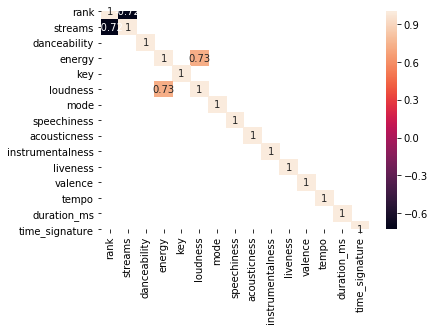

In [7]:
# let's see which numeric features are strongly correlated
sn.heatmap(dat.select_dtypes(exclude=['object']).corr()[abs(dat.select_dtypes(exclude=['object']).corr()) > 0.5], annot=True)
plt.show()

## Modelling song and artist popularity

In [8]:
print('Number of different artists with a #1 song:', len(dat.artist[dat['rank']==1].unique()))
print('Total number of artists included in dataset:', len(dat.artist.unique()))
print('\nProportion of artists in dataset with a #1 song:', len(dat.artist[dat['rank']==1].unique())/len(dat.artist.unique()))

Number of different artists with a #1 song: 40
Total number of artists included in dataset: 813

Proportion of artists in dataset with a #1 song: 0.04920049200492005


* Wow, very few artists have a number one song! This is not too surprising, however, since it often seems like we see the same names over and over in the number one song position (e.g., Drake, Post Malone, etc.). Keep in mind that this dataset only includes songs and artists that reach the top 200 -- I can only imagine how small the proportion of ALL artists that reach the number one song position must be.

In [9]:
print('Number of different #1 songs:', len(dat.title[dat['rank']==1].unique()))
print('Total number of songs included in dataset:', len(dat.title.unique()))
print('\nProportion of songs in dataset that have been at #1 position:', len(dat.title[dat['rank']==1].unique())/len(dat.title.unique()))

Number of different #1 songs: 79
Total number of songs included in dataset: 4933

Proportion of songs in dataset that have been at #1 position: 0.016014595580782484


* Wow, very few songs ever reach the number one position. Again, I can only imagine how small this proportion becomes once we include the population of ALL songs. These number one songs must be bops.

__Let's now examine the breakdown of number one songs by artist:__

In [10]:
num_one_artists = dat['artist'].groupby(dat.title[dat['rank']==1]).unique().apply(pd.Series)[0]
print('Artists with #1 songs:', num_one_artists.unique())

Artists with #1 songs: ['Taylor Swift' 'Logic' 'Ariana Grande' 'Harry Styles' 'Mariah Carey'
 'Kanye West' 'DaBaby' 'Lil Uzi Vert' 'Migos' '21 Savage' 'Post Malone'
 'The Weeknd' 'Luis Fonsi' 'Lil Baby' 'Tyler, The Creator' 'Lil Peep'
 'Drake' 'Travis Scott' 'Kendrick Lamar' 'Ed Sheeran' 'J. Cole'
 'Selena Gomez' 'Juice WRLD' 'Eminem' 'Sheck Wes' 'Lil Wayne' 'Lil Nas X'
 'Arizona Zervas' 'Lil Tecca' 'XXXTENTACION' 'Shawn Mendes'
 'Jonas Brothers' 'Roddy Ricch' 'Young Thug' 'Childish Gambino' 'NAV'
 'French Montana' 'DJ Khaled' 'Kodak Black' 'Billie Eilish']


In [11]:
num_one_artists_freq_dict = dict(zip(Counter(num_one_artists).keys(), Counter(num_one_artists).values()))
print('Number of different number one songs by artist:', num_one_artists_freq_dict)

Number of different number one songs by artist: {'Taylor Swift': 5, 'Logic': 2, 'Ariana Grande': 4, 'Harry Styles': 1, 'Mariah Carey': 1, 'Kanye West': 3, 'DaBaby': 1, 'Lil Uzi Vert': 5, 'Migos': 1, '21 Savage': 1, 'Post Malone': 8, 'The Weeknd': 3, 'Luis Fonsi': 2, 'Lil Baby': 2, 'Tyler, The Creator': 1, 'Lil Peep': 1, 'Drake': 7, 'Travis Scott': 3, 'Kendrick Lamar': 1, 'Ed Sheeran': 2, 'J. Cole': 2, 'Selena Gomez': 1, 'Juice WRLD': 1, 'Eminem': 1, 'Sheck Wes': 1, 'Lil Wayne': 1, 'Lil Nas X': 3, 'Arizona Zervas': 1, 'Lil Tecca': 1, 'XXXTENTACION': 2, 'Shawn Mendes': 1, 'Jonas Brothers': 1, 'Roddy Ricch': 1, 'Young Thug': 1, 'Childish Gambino': 1, 'NAV': 1, 'French Montana': 1, 'DJ Khaled': 1, 'Kodak Black': 1, 'Billie Eilish': 2}


* We observe that only some of the biggest names in music have had a number one song. Artists with more than one number one song are in an even more exclusive group, as we can see how the number of artists with many number one hits is quite few.

__So, if an artist has a number one song, just how many do they have?__ -- 

__Modelling the probability that artists have a certain frequency of number one songs__

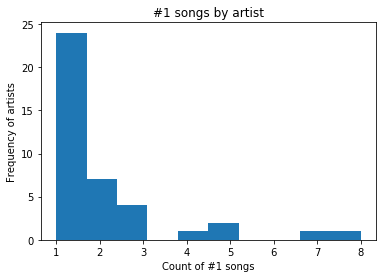

In [12]:
num_one_songs_by_art = [x for x in Counter(num_one_artists).values()]
plt.hist(num_one_songs_by_art)
plt.title('#1 songs by artist')
plt.xlabel('Count of #1 songs')
plt.ylabel('Frequency of artists')
plt.show()

* We can once again see that the number of artists with a particular count of number one hits decreases significantly for each additional number one song.


* We can now try to model the probability that artists have a certain frequency of number one songs -- let's try using Poisson and Geometric distributions (since there is no clear maximum to the number of number one songs artists can have) with different parameters and maximize the log-likelihood.

The log-likelihoods for each of the Poisson models are listed as follows: [-83.90186972055454, -69.14324245631886, -77.11149891577388, -94.38461519208325, -116.75627463826056, -142.35287165153824, -170.17496794518487, -199.62598792784743].


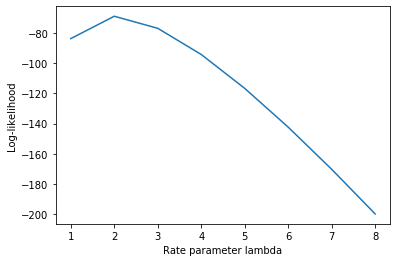

In [13]:
### Poisson model

data = num_one_songs_by_art
rate = list(range(1,9))
n = len(data)

def log_likelihood_poisson(x, n, intensity):
    ## probability mass function: p(X=k) = (lambda^k * e^-lambda) / k!
    x = np.array(x)
    loglik = -n*intensity + sum(x*np.log(intensity) - np.log(scipy.special.factorial(x))) # = log(joint pmf)
    return loglik

loglik = []
for intensity in rate:
    loglik.append(log_likelihood_poisson(data, n, intensity))
    
print('The log-likelihoods for each of the Poisson models are listed as follows: {}.'.format(loglik))

line_graph = plt.plot(rate, loglik)
plt.xlabel('Rate parameter lambda')
plt.ylabel('Log-likelihood')
plt.show()

* We see that the log-likelihood using a Poisson model is maximized with rate parameter $\lambda=2$. This model suggests that the the proability of artists having a certain number of number one songs is drawn from a Poisson distribution with mean $2$.

The log-likelihoods for each of the Geometric models are listed as follows: [-96.21246383041704, -73.0801149986182, -62.06923498664801, -56.573828601839836, -54.75862726423568, -56.168363493731675, -61.2219371262608, -71.6938206374983, -94.01523925308085].


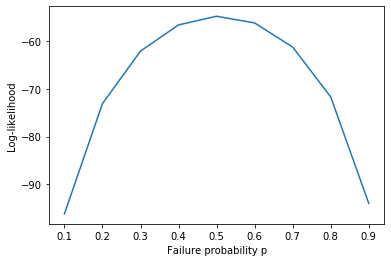

In [14]:
### Geometric model

data = num_one_songs_by_art
p_vals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
n = len(data)

def log_likelihood_geometric(x, n, p):
    ## probability mass function: p(X=k) = p*(1-p)^(k-1)
    x = np.array(x)
    loglik = n*np.log(p) + np.log(1-p)*sum(x-1) # = log(joint pmf)
    return loglik

loglik = []
for p in p_vals:
    loglik.append(log_likelihood_geometric(data, n, p))
    
print('The log-likelihoods for each of the Geometric models are listed as follows: {}.'.format(loglik))

line_graph = plt.plot(p_vals, loglik)
plt.xlabel('Failure probability p')
plt.ylabel('Log-likelihood')
plt.show()

* We see that the log-likelihood using a Geometric model is maximized with failure probability $p=0.5$. This model suggests that the proability of artists having an additional number one song after having at least one boils down to a coin flip.

* Since Geometric(0.5) has higher log-likelihood than Poisson(2), we choose to model the probability of artists with a certain number of number one songs as a draw from a Geometric distribution with failure probability $p=0.5$. This model suggests that the probability that an artist who has at least one number one song gets another can be modelled by a coin flip.


* We note that there are a couple of downfalls with using this model, such as the lack of independence between trials (whether or not an artist will get another number one song). There is also a potential issue with a non-constant probability of getting an additional number one song. These issues are due to the fact that more popular artists tend to accumulate number one songs with little difficulty, but newer, less popular artists have difficulty establishing themselves. Likewise, if an artist stops making music or puts out a very popular album, the probability of additional number one songs changes.


* Using the model, the fact that the proability an artist has an additional number one song after having at least one can simply come down to a coin flip, is quite an interesting finding!

__Now, let's examine just how long a number one song stays at number one -- Modelling the probability that a number one song stays at number one__

In [15]:
num_one_songs = dat.title[dat['rank']==1]
num_one_songs_freq_dict = dict(zip(Counter(num_one_songs).keys(), Counter(num_one_songs).values()))
print('Number of days each song is at the #1 position:', num_one_songs_freq_dict)

Number of days each song is at the #1 position: {'Bad and Boujee (feat. Lil Uzi Vert)': 29, 'Shape of You': 48, 'Passionfruit': 12, 'HUMBLE.': 64, 'Despacito (Featuring Daddy Yankee)': 2, 'Despacito - Remix': 46, 'XO TOUR Llif3': 4, 'Wild Thoughts (feat. Rihanna & Bryson Tiller)': 1, 'Unforgettable': 7, 'Bank Account': 20, 'Look What You Made Me Do': 10, '...Ready For It?': 2, '1-800-273-8255': 10, 'rockstar': 124, 'All I Want for Christmas Is You': 5, "God's Plan": 70, 'Psycho (feat. Ty Dolla $ign)': 1, 'Call Out My Name': 6, 'Nice For What': 32, 'KOD': 2, 'Paranoid': 1, 'Better Now': 8, 'This Is America': 13, 'All Mine': 4, 'Lucid Dreams': 20, 'SAD!': 6, 'Nonstop': 7, 'In My Feelings': 37, 'STARGAZING': 1, 'SICKO MODE': 19, 'Lucky You (feat. Joyner Lucas)': 9, 'I Love It (& Lil Pump)': 11, 'New Patek': 1, 'Falling Down - Bonus Track': 6, 'Mona Lisa (feat. Kendrick Lamar)': 7, 'Never Recover (Lil Baby & Gunna, Drake)': 1, 'Drip Too Hard (Lil Baby & Gunna)': 6, 'ZEZE (feat. Travis Scot

* Rather expectedly, we observe that most songs not to last quite long at the number one song position, but some notable ones last very long (e.g., Rockstar by Post Malone and The Box by Roddy Ricch). Some of these songs are so high because they are beloved songs or have little competition during a given day for the number one position.


* One possible downfall of only examining the top song for a given day is possibly ignoring a song that seems to be an eternal resident in the top 10 of the charts, such as Sunflower by Post Malone. 


* Now, let's check the distribution of the number of days a song stays at the number one position on the charts:

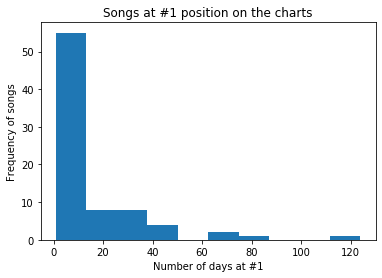

In [16]:
plt.hist(Counter(num_one_songs).values())
plt.title('Songs at #1 position on the charts')
plt.xlabel('Number of days at #1')
plt.ylabel('Frequency of songs')
plt.show()

* We can once again see that the number of days a song stays at the number one position on the charts decreases significantly for each additional increment of ten days. This distribution actually looks a lot like the total count of number one songs for particular artists. 


* We can now try to model the probability that a song stays at the number one position on the charts for a particular number of days -- let's try using Poisson and Geometric distributions (since there is no clear maximum to the number of days a number one song can stay at the position) with different parameters and maximize the log-likelihood.

The log-likelihoods for each of the Poisson models are listed as follows: [-1007.343636401162, -972.4479715349938, -947.4693760323862, -930.8183403625102, -921.2593136388127, -917.8128322119057, -919.6892994525081, -926.2428763818684, -936.9385718431301, -951.3282424251508, -969.0327556320277].


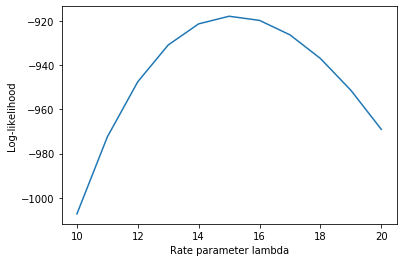

In [17]:
### Poisson model

data = list(Counter(num_one_songs).values())
rate = list(range(10,21))
n = len(data)

def log_likelihood_poisson(x, n, intensity):
    ## probability mass function: p(X=k) = (lambda^k * e^-lambda) / k!
    x = np.array(x)
    loglik = -n*intensity + sum(x*np.log(intensity) - np.log(scipy.special.factorial(x))) # = log(joint pmf)
    return loglik

loglik = []
for intensity in rate:
    loglik.append(log_likelihood_poisson(data, n, intensity))
    
print('The log-likelihoods for each of the Poisson models are listed as follows: {}.'.format(loglik))

line_graph = plt.plot(rate, loglik)
plt.xlabel('Rate parameter lambda')
plt.ylabel('Log-likelihood')
plt.show()

* We see that the log-likelihood using a Poisson model is maximized with rate parameter $\lambda=15$. This model suggests that the the proability a song stays at the number one position on the charts for a particular number of days is drawn from a Poisson distribution with mean $15$ days.

The log-likelihoods for each of the Geometric models are listed as follows: [-375.0246195055668, -293.90616614727173, -299.48655782066373, -331.24360412550146, -376.17379834895195, -430.57044738465885, -493.16308897737434].


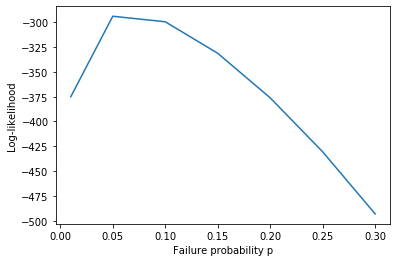

In [18]:
### Geometric model

data = list(Counter(num_one_songs).values())
p_vals = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
n = len(data)

def log_likelihood_geometric(x, n, p):
    ## probability mass function: p(X=k) = p*(1-p)^(k-1)
    x = np.array(x)
    loglik = n*np.log(p) + np.log(1-p)*sum(x-1) # = log(joint pmf)
    return loglik

loglik = []
for p in p_vals:
    loglik.append(log_likelihood_geometric(data, n, p))
    
print('The log-likelihoods for each of the Geometric models are listed as follows: {}.'.format(loglik))

line_graph = plt.plot(p_vals, loglik)
plt.xlabel('Failure probability p')
plt.ylabel('Log-likelihood')
plt.show()

* We see that the log-likelihood using a Geometric model is maximized with failure probability $p=0.05$. This model suggests that the proability a song loses its number one position on the charts for any particular day equals 0.05.

* Since Geometric(0.05) has higher log-likelihood than Poisson(15), we choose to model the probability of artists with a certain number of number one songs as a draw from a Geometric distribution with failure probability $p=0.05$. This model suggests that the proability a song loses its number one position on the charts for any particular day equals 0.05.


* We note that there are a couple of downfalls with using this model, such as the lack of independence between trials (whether or not a song will last another day at number one). There is also a potential issue with a non-constant probability of exiting the number one position. These issues are due to the irregular release of music, such that very popular albums can immediately flood the charts, causing songs to lose their spot at number one, while other periods of time can be without any new music.


* Using the model, the fact that the proability a song loses its number one position on the charts for any particular day is 0.05, is very interesting! It is also curious how we had observed that the distribution of the number of days a song stays at the number one position appeared to have the same shape as the distribution of the frequency of number one songs for particular artists, except for a scaling factor of approx. ten, and that both distributions were best modelled using a Geometric distribution with a parameter a factor of ten apart! 


* Now that we have seen that we can model the proability a song loses its number one position on the charts for any particular day, let's see the difference in modelling the proability a song in the top 200 exits the charts entirely on any particular day.

__Now, let's examine how long a song stays in the top 200 -- Modelling the probability that a song stays on the charts__

In [19]:
songs = dat.title
songs_freq_dict = dict(zip(Counter(songs).keys(), Counter(songs).values()))
print('Number of days some songs are in the top 200:', dict(islice(songs_freq_dict.items(), 10)))

Number of days some songs are in the top 200: {'Bad and Boujee (feat. Lil Uzi Vert)': 429, 'Fake Love': 455, 'Starboy': 464, 'Closer': 536, 'Black Beatles': 240, 'Broccoli (feat. Lil Yachty)': 393, 'One Dance': 498, 'Caroline': 389, 'Let Me Love You': 151, 'Bounce Back': 468}


* It makes sense that songs tend to spend significantly more days on the charts than at number one position. Now, let's check the distribution of the number of days a song stays on the charts:

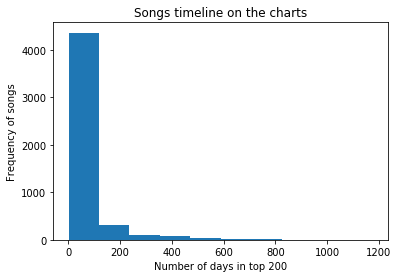

In [20]:
plt.hist(Counter(songs).values())
plt.title('Songs timeline on the charts')
plt.xlabel('Number of days in top 200')
plt.ylabel('Frequency of songs')
plt.show()

* We see a very steep decrease in the number of days a song stays on the charts followed by a more varying degree of decrease. This suggests that once a song gets past a baseline sense of popularity, its reception by consumers varies, but still tends to worsen over time.


* We can now try to model the probability that a song stays in the top 200 on the charts for a particular number of days -- let's just try the Geometric distribution (for comparison and since Poisson log-likelihood calculation requires us to take factorials, but some of our entries are too high, resulting in an overflow error) with different parameters and maximize the log-likelihood.

The log-likelihoods for each of the Geometric models are listed as follows: [-34310.12489479444, -27309.789995523828, -25069.59568432712, -24254.50719226127, -24026.473336149793, -24122.900623675083, -24426.858078482997, -24876.001358448775, -25433.143083535077, -26074.320579374667, -26783.194150142437].


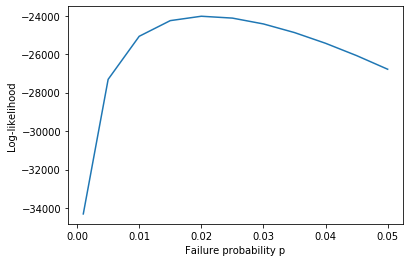

In [21]:
### Geometric model

data = list(Counter(songs).values())
p_vals = [0.001, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]
n = len(data)

def log_likelihood_geometric(x, n, p):
    ## probability mass function: p(X=k) = p*(1-p)^(k-1)
    x = np.array(x)
    loglik = n*np.log(p) + np.log(1-p)*sum(x-1) # = log(joint pmf)
    return loglik

loglik = []
for p in p_vals:
    loglik.append(log_likelihood_geometric(data, n, p))
    
print('The log-likelihoods for each of the Geometric models are listed as follows: {}.'.format(loglik))

line_graph = plt.plot(p_vals, loglik)
plt.xlabel('Failure probability p')
plt.ylabel('Log-likelihood')
plt.show()

* We see that the log-likelihood using a Geometric model is maximized with failure probability $p=0.02$. This model suggests that the proability a song exits the charts for any particular day equals 0.02.

* We note that many of the downfalls previously mentioned when discussing the probability a song exits the number one position on a certain day hold in this scenario as well.


* Using the model, the fact that the proability a song exits the top 200 on the charts for any particular day is 0.02, is very interesting! It makes sense that this probability is substantially lower than the probability of the top song exiting the number one position since there is much more competition for the top spot than there is for the top 200 (plus, there are many more opportunities to be in the top 200 than the number one position).

## Most important words in song titles 

* We break this task up into three parts:

    1. Finding the most frequently used words in song titles
    2. Finding the words which are most commonly used in English language
    3. Removing most common words in song titles which are also most common in English language
    
    
* The remaining words are the most frequently used words in song titles and are not simply prevalent due to being commonly used in English. Thus, we define the remaining words as the most important words in song titles.

__Part 1__: Finding the most frequently used words in song titles

In [22]:
# pre-process song titles
song_titles = np.asarray([x.lower() for x in dat.title.unique()]) # lowercase all song titles
song_titles = np.asarray([re.sub(r'\([^)]*\)', '', x) for x in song_titles]) # get rid of text in parentheses to remove featured artists
print('Some song titles:', song_titles[0:10])

Some song titles: ['bad and boujee ' 'fake love' 'starboy' 'closer' 'black beatles'
 'broccoli ' 'one dance' 'caroline' 'let me love you' 'bounce back']


In [23]:
song_titles_words = [re.findall(r'\b\w+\b',x) for x in song_titles] # extract words from each song
print('Words in some song titles:', song_titles_words[0:10])

Words in some song titles: [['bad', 'and', 'boujee'], ['fake', 'love'], ['starboy'], ['closer'], ['black', 'beatles'], ['broccoli'], ['one', 'dance'], ['caroline'], ['let', 'me', 'love', 'you'], ['bounce', 'back']]


In [24]:
song_titles_words_all = (list(chain.from_iterable(song_titles_words))) # aggregate words in song titles
print('Pooled words from some song titles:', song_titles_words_all[0:10])

Pooled words from some song titles: ['bad', 'and', 'boujee', 'fake', 'love', 'starboy', 'closer', 'black', 'beatles', 'broccoli']


In [25]:
# first ten elements in dictionary of song title words and frequency in song titles
print('Dictionary of some words in song titles and their frequency:',dict(islice(dict(zip(Counter(song_titles_words_all).keys(), Counter(song_titles_words_all).values())).items(), 10)))

Dictionary of some words in song titles and their frequency: {'bad': 38, 'and': 43, 'boujee': 1, 'fake': 4, 'love': 137, 'starboy': 1, 'closer': 4, 'black': 18, 'beatles': 1, 'broccoli': 1}


In [26]:
song_word_dict = dict(zip(Counter(song_titles_words_all).keys(), Counter(song_titles_words_all).values())) # save above dictionary

# sort dictionary by count and append to list
song_word_list = []
[song_word_list.append([w, song_word_dict[w]]) for w in sorted(song_word_dict, key=song_word_dict.get, reverse=True)]

print('Top 25 most frequent words in song titles:', song_word_list[0:25])

Top 25 most frequent words in song titles: [['the', 382], ['me', 244], ['i', 243], ['you', 237], ['it', 156], ['love', 137], ['a', 128], ['my', 122], ['t', 121], ['to', 117], ['in', 113], ['on', 109], ['up', 100], ['of', 92], ['s', 92], ['remix', 81], ['no', 69], ['for', 69], ['don', 65], ['christmas', 62], ['out', 58], ['like', 54], ['from', 50], ['what', 50], ['all', 50]]


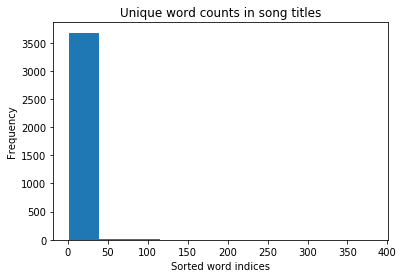

In [27]:
song_word_freq = np.asarray([value for word, value in song_word_list]) # extract counts of each word in song titles

# plot histogram of unique word counts in song titles
plt.hist(song_word_freq)
plt.title('Unique word counts in song titles')
plt.xlabel('Sorted word indices')
plt.ylabel('Frequency')
plt.show()

* We observe that most words are not very common in song titles! We want to find words that are frequently used in song titles, but we want these words to not just be the commonly used words in English -- we want to find what makes these song titles important by finding their prominent, unique words.

__Part 2__: Finding the words which are most commonly used in English language

In [28]:
url = 'https://www.rypeapp.com/most-common-english-words/' # webpage listing 100 most common words in English language
response = requests.get(url)

In [29]:
response # successful!

<Response [200]>

In [30]:
soup = BeautifulSoup(response.text, 'html.parser') # use BeautifulSoup library

In [31]:
soup.findAll('td')[0:5] # first five words on webpage (note: the words do not appear in the correct order of frequency)

[<td nowrap="nowrap" valign="bottom" width="90">1. the</td>,
 <td nowrap="nowrap" valign="bottom" width="90">21. at</td>,
 <td nowrap="nowrap" valign="bottom" width="90">41. there</td>,
 <td nowrap="nowrap" valign="bottom" width="100">61. some</td>,
 <td nowrap="nowrap" valign="bottom" width="90">81. my</td>]

In [32]:
english_word_rank_list = []
english_word_list = []

for text in soup.findAll('td'):
    english_word_rank_list.append(re.findall(r'[0-9]+', text.get_text())) # extract numbers => rank of words
    english_word_list.append(re.findall(r'[a-zA-Z]+', text.get_text())) # extract words
    
print('Some of the most frequently used words in English language:', english_word_list[0:5])
print('Corresponding rank of usage frequency:', english_word_rank_list[0:5])

Some of the most frequently used words in English language: [['the'], ['at'], ['there'], ['some'], ['my']]
Corresponding rank of usage frequency: [['1'], ['21'], ['41'], ['61'], ['81']]


In [33]:
# unlist individual elements
english_word_rank_list = (list(chain.from_iterable(english_word_rank_list)))
english_word_list = (list(chain.from_iterable(english_word_list)))

In [34]:
english_words_dict = dict(zip(np.asarray(english_word_rank_list).astype(int), english_word_list)) # concatenate lists into dictionary
print('Dictionary of some frequently used words in English language and their rank:',dict(islice(english_words_dict.items(), 10)))

Dictionary of some frequently used words in English language and their rank: {1: 'the', 21: 'at', 41: 'there', 61: 'some', 81: 'my', 2: 'of', 22: 'be', 42: 'use', 62: 'her', 82: 'than'}


In [35]:
# sort by rank of how common each word is and append to list
english_words_list = []
[english_words_list.append([w, english_words_dict[w]]) for w in sorted(english_words_dict)]
print('First four elements in list of most frequently used words in English language:', english_words_list[0:4])

First four elements in list of most frequently used words in English language: [[1, 'the'], [2, 'of'], [3, 'and'], [4, 'a']]


__Part 3__: Removing most common words in song titles which are also most common in English language

In [36]:
most_words_songs = np.asarray([word for word,count in song_word_list]) # list of most common words in song titles
most_words_english = np.char.lower(np.asarray([word for count,word in english_words_list])) # list of most common words in English language

print('Top 10 words in song titles:',most_words_songs[0:10])
print('Top 10 words in English language:',most_words_english[0:10])

Top 10 words in song titles: ['the' 'me' 'i' 'you' 'it' 'love' 'a' 'my' 't' 'to']
Top 10 words in English language: ['the' 'of' 'and' 'a' 'to' 'in' 'is' 'you' 'that' 'it']


In [37]:
# top 43 words in song titles NOT in most commmon English words
song_words = [word for word in most_words_songs[~np.in1d(most_words_songs, most_words_english)]][0:43] 
song_words

['me',
 'love',
 't',
 's',
 'remix',
 'don',
 'christmas',
 'good',
 'm',
 'bad',
 'back',
 'let',
 'off',
 'life',
 'know',
 '2',
 'u',
 'feat',
 'big',
 'girl',
 'feel',
 'never',
 'la',
 'night',
 'version',
 'new',
 'too',
 'god',
 'man',
 'home',
 'right',
 'money',
 'heart',
 'high',
 'remastered',
 'talk',
 'better',
 'say',
 'want',
 'summer',
 'baby',
 'boy',
 'black']

In [38]:
# extract top 35 words in song titles NOT in most commmon English words
### IMPORTANT NOTE: we remove words that were part of contractions (e.g. 't', 'don'), slang (e.g., 'u'), numbers (e.g., '2'), 
### other languages (e.g., 'la'), and 'feat' (we do not want to take feat or featuring artists into account)

# these indices taken directly from above list DO NOT correspond to contractions, numbers, 'feat'
want_to_remove = ['t','s','don','m','2','u','feat','la']
idxs_real_words = [i for i, x in enumerate(song_words) if x not in want_to_remove]

song_words = [word for word in np.take([word for word in most_words_songs[~np.in1d(most_words_songs, most_words_english)]], idxs_real_words)]

In [39]:
print('Top 35 most important words in song titles:\n\n',song_words)

Top 35 most important words in song titles:

 ['me', 'love', 'remix', 'christmas', 'good', 'bad', 'back', 'let', 'off', 'life', 'know', 'big', 'girl', 'feel', 'never', 'night', 'version', 'new', 'too', 'god', 'man', 'home', 'right', 'money', 'heart', 'high', 'remastered', 'talk', 'better', 'say', 'want', 'summer', 'baby', 'boy', 'black']


###### Notable words:
* __infatuated__ -- love, heart, girl, baby, feel (note: I manually went through song titles and saw that 'man' and 'boy' usually were not love-type songs)
* __seasonal__ -- christmas, summer
* __musical__ -- remix, remastered, version
* __profound__ -- life, god
* __enjoyment__ -- night, money

* We found that, after processing words that are very common, many words used in song titles are very thematic! That is, they tend to fall into a few notable categories which help us classify the songs.


* Some of these words suggest infatuation, perhaps indicating a love song, while others are associated with seasonal songs and enjoyment/party songs. Interestingly, there is a whole category dedicated to rather profound concepts, such as life and god. Another category has words with musical concepts, such as 'version' and 'remix'.

## Spotify usage (as measured by total weekly streams) over time (2017-present)

In [40]:
# total streams for each day appended to list 'strms'
strms = [sum(dat.streams[dat.date == date]) for date in dat.date.unique()]
print('Total streams for each day:', strms[0:7])

Total streams for each day: [55139058, 48894824, 55168814, 55939894, 56235124, 59503480, 54059621]


In [41]:
# total streams for each week appended to list 'tot_weekly_streams'
tot_weekly_streams = np.add.reduceat(np.asarray(strms), np.arange(0, len(strms), 7))
tot_weekly_streams = tot_weekly_streams[:-1] # remove last entry bc not a full week of data
print('Total streams for each week:', tot_weekly_streams[0:7]) # note that sum(strms[0:7]) = tot_weekly_streams[0]

Total streams for each week: [384940815 410773282 418037694 424685581 446362951 446611950 459244530]


C:\Users\willb\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


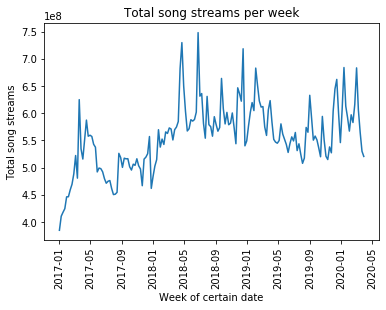

In [42]:
each_date = pd.to_datetime(dat.date.unique()) # convert each date to datetime object
dates = [each_date[0]+datetime.timedelta(7*wk) for wk in range(len(tot_weekly_streams))] # first day of each week

plt.plot(dates,tot_weekly_streams)
plt.title('Total song streams per week')
plt.xlabel('Week of certain date')
plt.ylabel('Total song streams')
plt.xticks(rotation=90)
plt.show()

In [43]:
# fit linear regression model between date (week) and total number of streams
streams_model = LinearRegression().fit(pd.DataFrame(pd.to_datetime(np.asarray(dates)).map(datetime.datetime.toordinal)), tot_weekly_streams)
print('𝑟-squared:', streams_model.score(pd.DataFrame(pd.to_datetime(np.asarray(dates)).map(datetime.datetime.toordinal)), tot_weekly_streams))

𝑟-squared: 0.251937642059627


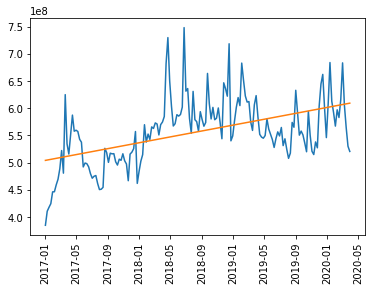

In [44]:
m = streams_model.coef_[0] # slope
b = streams_model.intercept_ # intercept
plt.plot(dates,tot_weekly_streams)
plt.plot(pd.to_datetime(np.asarray(dates)).map(datetime.datetime.toordinal), m*pd.to_datetime(np.asarray(dates)).map(datetime.datetime.toordinal) + b)
plt.xticks(rotation=90)
plt.show()

In [45]:
print('Slope -- Expected increase in total number of streams per week:', m)

Slope -- Expected increase in total number of streams per week: 88863.13070825336


* While it makes sense for the slope to suggest a modest increase in the total number of streams per week on the platform, we must note the clearly poor linear relationship between the date and total number of weekly streams on Spotify. Unfortunately, there does not even appear to be a constant seasonal effect for which we can account in our model. One reason I hypothesize that linear regression does not work well in this scenario is due to the lack of independence between observations; that is, the lack of independence between number of streams by week. This is largely due, I believe, to the seemingly random pattern by which music is released. When new music is released, many people are motivated to stream it on Spotify, thereby increasing the number of weekly streams on the platform. On the other hand, many users get bored of hearing the same songs on repeat, and are less inclined to stream music on the platform when no new music is released. Since this release timing is seemingly random (I am surprised not to see a "song of the summer" type effect; nevertheless, I digress), there are random surges of streaming and equally random periods of decreased listening on the platform.

## Song categories and muscial attributes

Let's now examine the categories of songs we defined using their titles and see if they have any notable musical attributes:

In [46]:
unique_songs_dat = dat.drop_duplicates(['title'])

In [47]:
unique_songs_dat_copy = unique_songs_dat.copy()
unique_songs_dat_copy.title = unique_songs_dat_copy.title.str.lower() # lowercase all song titles
unique_songs_dat.loc[:,'title'] = unique_songs_dat_copy['title']
print(unique_songs_dat.title.head())

0    bad and boujee (feat. lil uzi vert)
1                              fake love
2                                starboy
3                                 closer
4                          black beatles
Name: title, dtype: object


C:\Users\willb\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [48]:
song_titles_words = [re.findall(r'\b\w+\b',x) for x in unique_songs_dat.title] # extract words from each song
print(song_titles_words[0:5])

[['bad', 'and', 'boujee', 'feat', 'lil', 'uzi', 'vert'], ['fake', 'love'], ['starboy'], ['closer'], ['black', 'beatles']]


In [49]:
song_titles_words[0]

['bad', 'and', 'boujee', 'feat', 'lil', 'uzi', 'vert']

In [51]:
infatuated_words = ['love', 'heart', 'girl', 'baby', 'feel']
seasonal_words = ['christmas', 'summer']
musical_words = ['remix', 'remastered', 'version']
profound_words = ['life', 'god']
enjoyment_words = ['night', 'money']

In [52]:
infatuated_songs_list = []
seasonal_songs_list = []
musical_songs_list = []
profound_songs_list = []
enjoyment_songs_list = []

for song_ix in range(len(unique_songs_dat.title)):
    infatuated_songs_list.append(any(song_titles_words[song_ix][x] in infatuated_words for x in range(len(song_titles_words[song_ix]))))
    seasonal_songs_list.append(any(song_titles_words[song_ix][x] in seasonal_words for x in range(len(song_titles_words[song_ix]))))
    musical_songs_list.append(any(song_titles_words[song_ix][x] in musical_words for x in range(len(song_titles_words[song_ix]))))
    profound_songs_list.append(any(song_titles_words[song_ix][x] in profound_words for x in range(len(song_titles_words[song_ix]))))
    enjoyment_songs_list.append(any(song_titles_words[song_ix][x] in enjoyment_words for x in range(len(song_titles_words[song_ix]))))


In [53]:
infatuated_ixs = np.asarray(infatuated_songs_list).astype(int)
seasonal_ixs = np.asarray(seasonal_songs_list).astype(int)
musical_ixs = np.asarray(musical_songs_list).astype(int)
profound_ixs = np.asarray(profound_songs_list).astype(int)
enjoyment_ixs = np.asarray(enjoyment_songs_list).astype(int)

In [54]:
print(sum(infatuated_ixs))
print(sum(seasonal_ixs))
print(sum(musical_ixs))
print(sum(profound_ixs))
print(sum(enjoyment_ixs))

265
85
134
57
48


In [ ]:
## check christmas vs summer




In [55]:
pd.options.mode.chained_assignment = None
unique_songs_dat['infatuated'] = infatuated_ixs
unique_songs_dat['seasonal'] = seasonal_ixs
unique_songs_dat['musical'] = musical_ixs
unique_songs_dat['profound'] = profound_ixs
unique_songs_dat['enjoyment'] = enjoyment_ixs

In [56]:
unique_songs_dat.head()

,rank,date,artist,title,streams,danceability,energy,key,loudness,mode,...,valence,tempo,uri,duration_ms,time_signature,infatuated,seasonal,musical,profound,enjoyment
0,1,2017-01-01,Migos,bad and boujee (feat. lil uzi vert),1371493,0.927,0.665,11.0,-5.313,1.0,...,0.175,127.076,spotify:track:4Km5HrUvYTaSUfiSGPJeQR,343150.0,4.0,0,0,0,0,0
1,2,2017-01-01,Drake,fake love,1180074,0.928,0.481,9.0,-9.350,0.0,...,0.613,134.007,spotify:track:343YBumqHu19cGoGARUTsd,210937.0,4.0,1,0,0,0,0
2,3,2017-01-01,The Weeknd,starboy,1064351,0.679,0.587,7.0,-7.015,1.0,...,0.486,186.003,spotify:track:7MXVkk9YMctZqd1Srtv4MB,230453.0,4.0,0,0,0,0,0
3,4,2017-01-01,The Chainsmokers,closer,1010492,0.748,0.524,8.0,-5.599,1.0,...,0.661,95.010,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,244960.0,4.0,0,0,0,0,0
4,5,2017-01-01,Rae Sremmurd,black beatles,874289,0.794,0.632,0.0,-6.163,1.0,...,0.355,145.926,spotify:track:6fujklziTHa8uoM5OQSfIo,291893.0,4.0,0,0,0,0,0


In [57]:
len(unique_songs_dat.key)

4933

In [58]:
#unique_songs_dat.dropna()
#len(unique_songs_dat.artist)
clean_data = unique_songs_dat[unique_songs_dat.key.notna()]
len(clean_data.artist)

4828

In [59]:
musical_features = list(clean_data.iloc[:, 5:19])
del musical_features[11]

for song_type in list(['infatuated', 'seasonal', 'musical', 'profound', 'enjoyment']):
    print('\n\nSong type:\n', song_type.upper())
    for feature in musical_features:
        model = LinearRegression().fit(clean_data[[song_type]], clean_data[[feature]])
        print('\nFeature:', feature)
        print('Slope:', *model.coef_[0])



Song type:
 INFATUATED

Feature: danceability
Slope: -0.016253158642173245

Feature: energy
Slope: 0.0009713710285316907

Feature: key
Slope: 0.281324676514562

Feature: loudness
Slope: -0.012348672949662555

Feature: mode
Slope: -0.004434467909661248

Feature: speechiness
Slope: -0.012400192238015301

Feature: acousticness
Slope: 0.01688165277753946

Feature: instrumentalness
Slope: -0.0040639379215055855

Feature: liveness
Slope: -0.004254701876985995

Feature: valence
Slope: 0.01022022663762549

Feature: tempo
Slope: -0.12323252304065835

Feature: duration_ms
Slope: -4649.827894502309

Feature: time_signature
Slope: -0.0016591773245765316


Song type:
 SEASONAL

Feature: danceability
Slope: -0.13108881578947365

Feature: energy
Slope: -0.12918491050859468

Feature: key
Slope: 0.11029151160730165

Feature: loudness
Slope: -2.6508343301435406

Feature: mode
Slope: 0.19519758993443304

Feature: speechiness
Slope: -0.08289899211412372

Feature: acousticness
Slope: 0.2575943703244062



In [60]:
clean_data[musical_features].describe().iloc[[2]] # stdev

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
std,0.151638,0.172021,3.684613,2.691636,0.490482,0.132605,0.24606,0.08523,0.1393,0.218618,29.535939,55967.440219,0.337426


* danceability, energy almost one standard deviation lower for seasonal
* loudness almost one standard deviation lower for seasonal
* tempo slightly higher enjoyment, profound, slightly lower seasonal
* seasonal slightly shorter, profound slighly longer
* seasonal slightly time_signature

## Musical attributes

In [61]:
clean_data[musical_features].describe().iloc[[3,5,7]] # get min, median, max for each musical feature variable to find important differences

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
min,0.148,0.0137,0.0,-34.4750,0.0,0.0229,0.000002,0.000,0.0215,0.0262,46.718,30133.0,1.0
50%,0.693,0.6300,5.0,-6.3075,1.0,0.0939,0.123000,0.000,0.1270,0.4470,122.019,203801.0,4.0
max,0.980,0.9960,11.0,0.1750,1.0,0.9660,0.994000,0.956,0.9630,0.9800,232.690,943529.0,5.0


* Danceability -- b/w 0 and 1. appears continuous and pretty symmetric
* Energy -- b/w 0 and 1. appears continuous and pretty symmetric
* Key -- b/w 0 and 11. appears discrete and pretty symmetric
* Loudness -- b/w -35 and 0.175. can't tell much
* Mode -- b/w 0 and 1. appears binary
* Speechiness -- b/w 0 and 1. appears continuous and right skewed
* Instrumentalness -- b/w 0 and 1. appears continuous, pretty zero-inflated, and right-skewed
* Liveness -- b/w 0 and 1. appears continuous and right skewed
* Valence -- b/w 0 and 1. appears continuous and pretty symmetric
* Tempo -- b/w 46.7 and 232.7. appears continuous and pretty symmetric
* Duration(ms) -- b/w 30,000 and 943,529. probably technically discrete, but can be treated continuous and slightly right skewed
* Time signature -- b/w 1 and 5. appears discrete and a bit left skewed (pretty symmetric)
